In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from utils.data_utils import preprocessing, custom_train_test_split


In [5]:



df = pd.read_csv('../cleaned_data.csv', sep=';')
df, bins = preprocessing(df, 50_000)
# print(df.head())
# print(bins)
X_train, X_test, y_train, y_test = custom_train_test_split(df, 10)



Bins from 0 to 65450000 step 50000 -> 1309 classes
Rows after filtering rare bins: 22062
Number of classes after filtering: 82


In [6]:
# --- 5) pipeline (TFIDF ONLY) ---
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=30000,
        ngram_range=(1,2),
        min_df=2
    )),
    ("clf", DecisionTreeClassifier(random_state=42))
])



In [8]:
# --- 6) grid search ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "clf__max_depth": [6, 10, 20, None],
    "clf__min_samples_leaf": [1, 3, 5]
}


grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=2,
    n_jobs=1,        # set to 1 to avoid loky worker issues; change if you have stable multiprocessing
    refit=True
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score (mean accuracy):", grid.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=   7.2s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=   7.0s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=   7.2s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=   7.1s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=   7.1s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=   7.0s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=   6.8s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=   6.6s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=   6.5s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=   6.5s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=5; total time=   6.4s
[CV] END ..........clf__max_depth=6, clf__min_sa

In [21]:
# --- 7) evaluate on test set ---
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))


# Optional: show confusion matrix (may be large)
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

print(cm_normalized)

Test accuracy: 0.6551099025606164
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1800
           1       0.62      0.62      0.62      1254
           2       0.59      0.53      0.56       502
           3       0.56      0.59      0.57       331
           4       0.52      0.47      0.49       144
           5       0.45      0.39      0.42        71
           6       0.63      0.46      0.54        41
           7       0.41      0.44      0.43        36
           8       0.43      0.50      0.46        12
           9       0.56      0.45      0.50        11
          10       0.00      0.00      0.00         4
          11       0.50      0.50      0.50         4
          12       0.50      0.50      0.50         4
          13       0.00      0.00      0.00         2
          49       1.00      0.50      0.67         2
          85       0.50      0.50      0.50         2
          99       0.00      0.00      0.00    

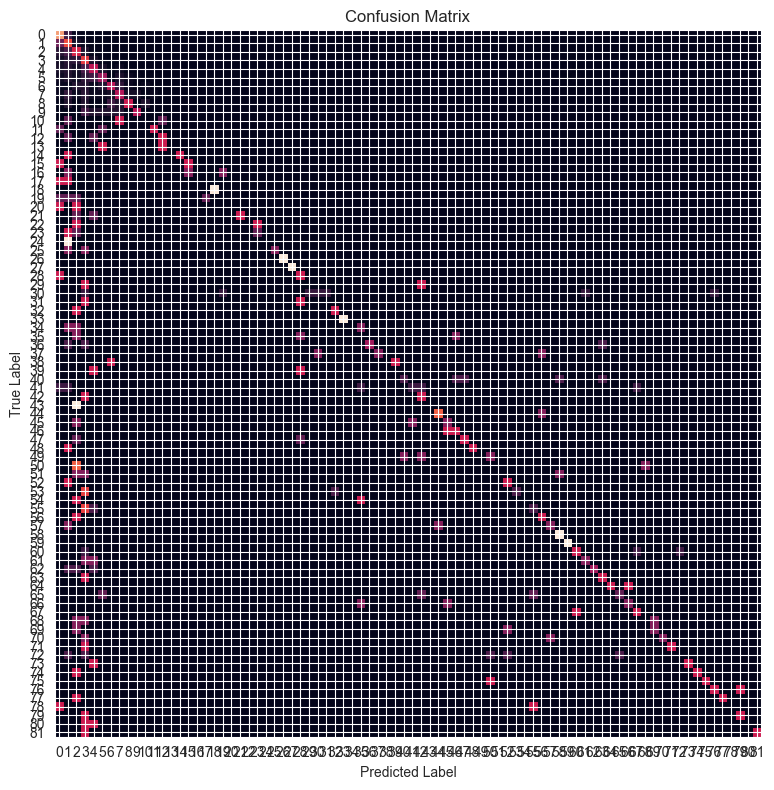

In [31]:

# --- PLOT ---
plt.figure(figsize=(8, 8))
plt.imshow(cm_normalized, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# # add numbers inside cells
# for i in range(min(cm_normalized.shape[0],100)):
#     for j in range(min(cm_normalized.shape[1],100)):
#         plt.text(j, i, str(cm_normalized[i, j]),
#                  ha="center", va="center")

# ticks
plt.xticks(np.arange(cm_normalized.shape[1]))
plt.yticks(np.arange(cm_normalized.shape[0]))

plt.tight_layout()

# save figure
plt.savefig("confusion_matrix.png", dpi=150)

# show plot
plt.show()


In [13]:
# --- 8) helper: convert predicted bin index to price range ---
def bin_to_range(bins, bin_idx):
    low = int(bins[bin_idx])
    high = int(bins[bin_idx+1] - 1)
    return (low, high)

# predict for new descriptions
new_descriptions = ["Excellent condition car, hardly used, my favourite BMW car I've ever had."]
pred_bins = best_model.predict(new_descriptions)
print("Predicted bin indices:", pred_bins)
print("Predicted price ranges:", [bin_to_range(bins, b) for b in pred_bins])


Predicted bin indices: [1]
Predicted price ranges: [(50000, 99999)]


In [11]:
# --- 9) save model if wanted ---
# import joblib
# joblib.dump(best_model, "tfidf_svd_dt_price_classifier.joblib")
